In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from IPython.display import clear_output
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
data_path = 'C:/Users/astro/pythonprojects/cycleGANs/horse2zebra/'

In [4]:
# For train horses
horse_train = []
data = data_path + 'trainA'
for image_name in os.listdir(data):
    full_image_path = os.path.join(data, image_name)
    img_arr = plt.imread(full_image_path)
    horse_train.append(img_arr)
horse_train = np.array(horse_train)
horse_train.shape

(1067, 100, 100, 3)

In [5]:
# For train zebras
zebra_train = []
data = data_path+'trainB'
for image_name in os.listdir(data):
    full_image_name = os.path.join(data, image_name)
    img_arr = plt.imread(full_image_name)
    zebra_train.append(img_arr)
zebra_train = np.array(zebra_train)
zebra_train.shape

(1327, 100, 100, 3)

In [6]:
# For test horses
horse_test = []
data = data_path + 'testA'
for image_name in os.listdir(data):
    full_image_path = os.path.join(data, image_name)
    img_arr = plt.imread(full_image_path)
    horse_test.append(img_arr)
horse_test = np.array(horse_test)
horse_test.shape

(120, 100, 100, 3)

In [7]:
# For test zebras
zebra_test = []
data = data_path + 'testB'
for image_name in os.listdir(data):
    full_image_path = os.path.join(data, image_name)
    img_arr = plt.imread(full_image_path)
    zebra_test.append(img_arr)
zebra_test = np.array(zebra_test)
zebra_test.shape

(140, 100, 100, 3)

Setting Image Constants

In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 100
IMG_HEIGHT = 100

In [9]:
# Inputing Pipelines
train_horses = tf.data.Dataset.from_tensor_slices(horse_train)
train_zebras = tf.data.Dataset.from_tensor_slices(zebra_train)

test_horses = tf.data.Dataset.from_tensor_slices(horse_test)
test_zebras = tf.data.Dataset.from_tensor_slices(zebra_test)

In [10]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[100,100,3])
    return cropped_image

In [11]:
def normalize(image): 
    image = tf.cast(image, tf.float32)
    image = image/127.5-1 # setting pixel values from -1 to 1
    return image

In [12]:
def random_jitter(image):
    # Resizing image to some higher value;
    image = tf.image.resize(image, size=[130, 130], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # Resizing back to original shape
    image = random_crop(image)
    
    # Also adding random mirroring
    image = tf.image.random_flip_left_right(image)
    
    return image

In [13]:
def preprocess_image_train(image):
    image = random_jitter(image)
    image = normalize(image)
    return image

In [14]:
def preprocess_image_test(image):
    image = normalize(image)
    return image

# # Setting up Input Pipeline

In [15]:
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size=BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size=BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size=BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size=BUFFER_SIZE).batch(1)

In [16]:
# Sample images
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

In [17]:
sample_horse.shape

TensorShape([1, 100, 100, 3])

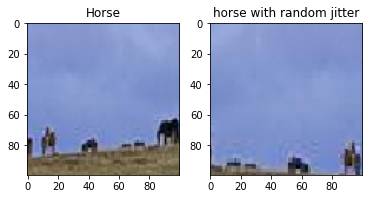

In [18]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0]*0.5+0.5)

plt.subplot(122)
plt.title('horse with random jitter')
plt.imshow(random_jitter(sample_horse[0])*0.5+0.5)

In [19]:
def VGG_block(inp_layer,convo_number, filters, pooling_layer=False):
    for layer in range(convo_number):
        inp_layer = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inp_layer)
    if pooling_layer:
        inp_layer = MaxPooling2D((2,2),strides=(1,1))(inp_layer)
    return inp_layer

In [20]:
def downsample(input_layer,filters, kernel_size = (4,4), strides=2, apply_batch_norm=True):
    convo = Conv2D(filters, kernel_size=kernel_size, strides=strides,activation='relu',padding='same')(input_layer)
    if apply_batch_norm:
        batchnorm = BatchNormalization()(convo)
        leaky = LeakyReLU()(batchnorm)
    else:
        leaky = LeakyReLU()(convo)
    
    return leaky

In [21]:
def upsample(inp_layer, filters, kernel_size=(4,4),strides=2, apply_dropout=False):
    convotrans = Conv2DTranspose(filters, kernel_size=kernel_size, strides=strides, activation='relu',padding='same')(inp_layer)
    if apply_dropout:
        drop = Dropout(0.2)(convotrans)
        leaky = LeakyReLU()(drop)
    else:
        leaky = LeakyReLU()(convotrans)
        
    return leaky

# Generator model:

In [22]:
def resnet_generator():
    input_layer = Input(shape=[100,100,3]) 

    # Downsampling
    down1 = downsample(input_layer,64, apply_batch_norm=False) #(bs, 50, 50, 64)
    down2 = downsample(down1, 128) #(bs, 25, 25, 128)
    down3 = downsample(down2, 256,strides=5) #(bs, 5, 5, 256)
    down4 = downsample(down3, 256, strides=5) #(bs, 1, 1, 256)

    # Upsampling
    up1 = upsample(inp_layer=down4,filters=256,apply_dropout=True,strides=5) #(bs, 5, 5, 256)
    add1 = add([up1,down3]) #(bs, 5, 5, 256)
    up2 = upsample(inp_layer=add1,filters=128, strides=5,apply_dropout=True) #(bs, 25, 25, 128)
    add2 = add([up2, down2]) #(bs, 25, 25, 128)
    up3 = upsample(inp_layer=add2,filters=64, strides=2) #(bs, 50 ,50, 64)
    add3 = add([up3, down1]) #(bs, 50 ,50, 64)

    last = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(add3)
    
    return tf.keras.models.Model(inputs=input_layer,outputs=last)

# Discriminator model:

In [23]:
# Defining Discriminator
def Discriminator():
    inp = Input(shape=[100,100,3]) #(bs, 100, 100, 3)
    vgg = VGG_block(inp,12,128) #(bs, 100, 100, 128)
    down1 = downsample(vgg, 256) #(bs, 50, 50, 256)
    down2 = downsample(down1, 256) #(bs, 25, 25, 256)
    down3 = downsample(down2, 256,strides=5) #(bs, 5, 5, 256)
    down4 = downsample(down3,128, strides=5) #(bs, 1, 1, 128)
    downlast = downsample(down4, 1, strides=1) #(bs, 1, 1, 1)
    flat = Flatten()(downlast)
    den1 = Dense(1,activation='sigmoid')(flat)
    return tf.keras.models.Model(inputs=inp,outputs=den1)

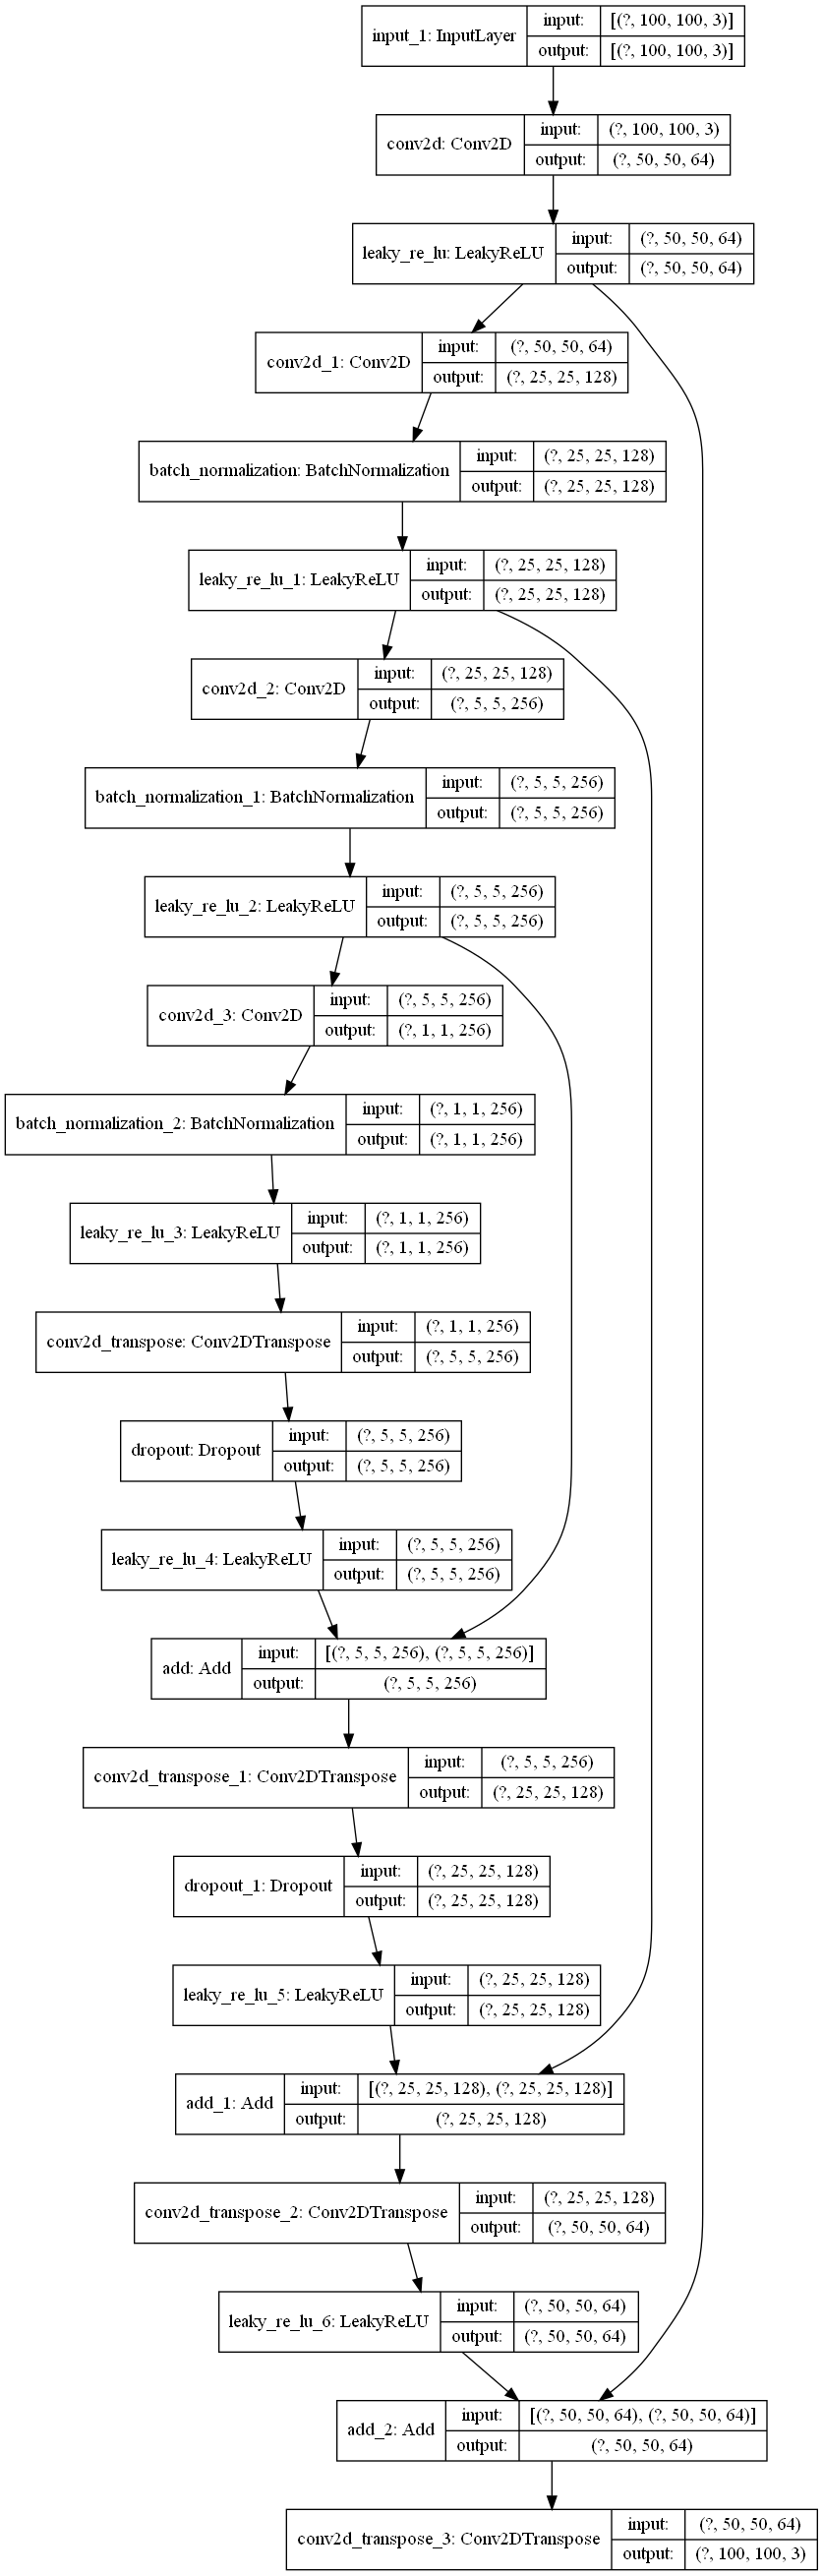

In [24]:
generator_g = resnet_generator()
generator_f = resnet_generator()
tf.keras.utils.plot_model(generator_g,show_shapes=True, to_file='generator_g.png')

# Generator i/p & o/p

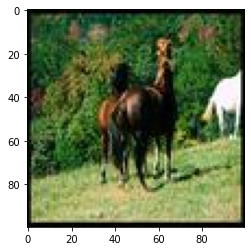

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


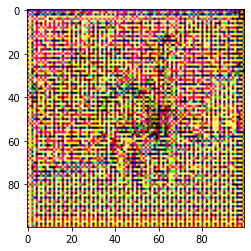

In [25]:
plt.imshow(horse_test[0])
plt.show()
sample_horse1 = horse_test[0]
sample_horse1 = sample_horse1.reshape(1,100,100,3)
gen_g_op = generator_g(sample_horse1).numpy()
gen_g_op = gen_g_op.reshape(100,100,3)
plt.imshow(gen_g_op)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


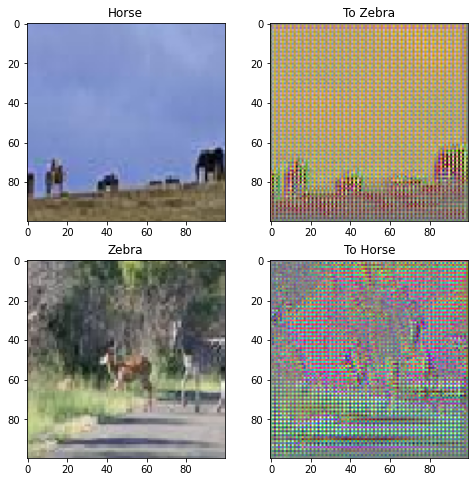

In [26]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

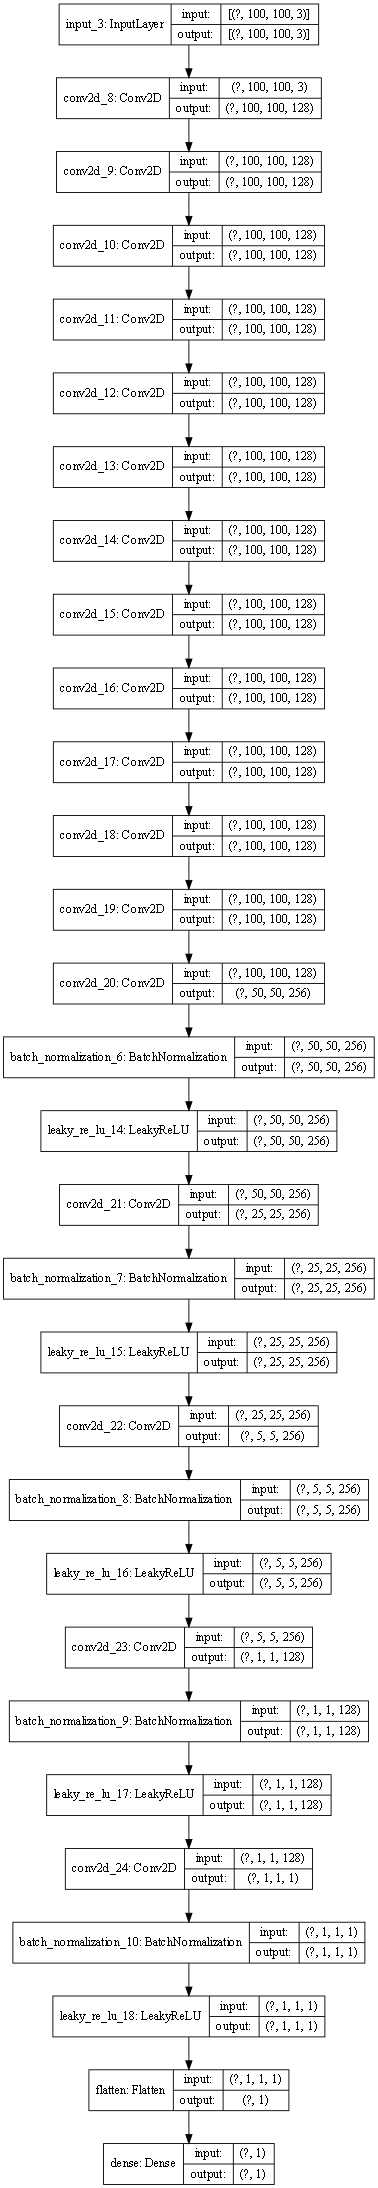

In [27]:
# Creating Discriminator
discriminator_x = Discriminator()
discriminator_y = Discriminator()
tf.keras.utils.plot_model(discriminator_x,show_shapes=True, to_file='roughdis.png', dpi=64)

In [28]:
LAMBDA = 10

Creating loss object

In [29]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
# Discriminator loss
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    
    fake_loss = loss_obj(tf.zeros_like(generated), generated)
    
    total_disc_loss = fake_loss+real_loss
    return total_disc_loss*0.5

In [31]:
# Generator loss
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [32]:
# Cycle_loss
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return loss1*LAMBDA

In [33]:
# Identity loss
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA*0.5*loss

In [34]:
# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.7)
generator_f_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.7)

discriminator_x_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.7)
discriminator_y_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.7)

In [35]:
# Setting Checkpoints
checkpoint_path = '/checkpoints(horse2zebra)/train'
ckpt = tf.train.Checkpoint(generator_g = generator_g, 
                          generator_f = generator_f,
                          generator_g_optimizer = generator_g_optimizer,
                          generator_f_optimizer = generator_f_optimizer,
                          discriminator_x=discriminator_x,
                          discriminator_y=discriminator_y,
                          discriminator_x_optimizer = discriminator_x_optimizer,
                          discriminator_y_optimizer = discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt,checkpoint_path,max_to_keep=20)

# if checkpoint exists then restore it
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Checkpoint restored !!!!')

In [36]:
EPOCHS = 50

In [37]:
def generate_images(model, test_input):
    prediction = model(test_input)
    
    plt.figure(figsize=(12,12))
    
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Generated Image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5+0.5)
        plt.axis('off')
    plt.show()

In [38]:
@tf.function
def train_step(real_x, real_y):
    # Persistent is set to True because to gradient tape is used more than once to calculate gradients
    with tf.GradientTape(persistent=True) as tape:
        
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # for identity loss
        same_x = generator_f(real_x,training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate loss
        gen_g_loss = generator_loss(disc_fake_y) # disc_fake_y = G(X) 
        gen_f_loss = generator_loss(disc_fake_x) # disc_fake_x = F(Y)
        
        total_cycle_loss = calc_cycle_loss(real_x,cycled_x)+calc_cycle_loss(real_y, cycled_y)
        
        # total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_x,same_x)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_y, same_y)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculating the gradients for generator and discriminator:
    generator_g_gradients = tape.gradient(total_gen_g_loss,generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss,discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Applying gradients to optimizers
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients,generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

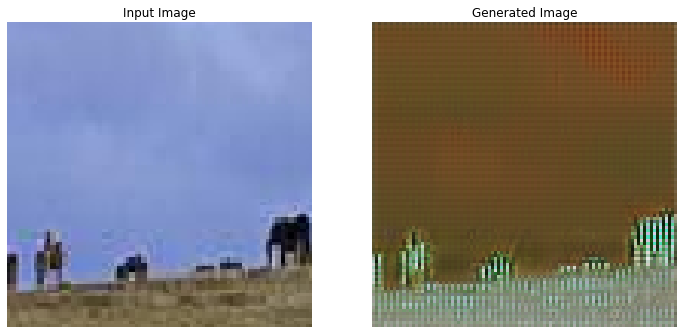

Time taken for epoch 2 is 3.6309120059013367 minutes, or 217.8547203540802 seconds
....................................

KeyboardInterrupt: 

In [39]:
for epoch in range(EPOCHS):
    start = time.time()
    
    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_horses,train_zebras)):
        train_step(image_x,image_y)
        if n%10==0:
            print('.',end='')
        n+=1
    
    clear_output(wait=True)
    # Generating Images
    generate_images(generator_g, sample_horse)
    
    if (epoch+1)%5==0:
        ckpt_save_path = ckpt_manager.save()
        print(f"Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}")
        
    print(f'Time taken for epoch {epoch+1} is {(time.time()-start)/60} minutes, or {time.time()-start} seconds')